# **Projeto Big Data - Detecção de Contas Falsas no Instagram**

<br>

**Integrantes :**

Caio Travain, Joseph Kallas e Thomas Chabro

___

## **Introdução**

A proposta entregue aos alunoso, foi da criação de um algoritmo a partir das técnicas aprendidas em aula, que fosse capaz de análisar grandes volumes de dados, e prever algum tipo de comportamento. Ainda, a ideia é de que esta previsão fosse de fato útil e aplicável em um mundo real, tendo um impacto e uso prático na vida de um usuário.

Para isso, foi escolhido o tema de **detecção de contas falsas no Instagram**, que se torna cada vez mais relevante, dada a massiva presença e influência de contas em plataformas de redes sociais. Ainda, a detecção de contas falsas é um problema que pode ser aplicado em diversas outras plataformas, como o Twitter, Facebook, entre outros.

Este projeto aplica uma análise de dados obtidos de um dataset público, que explora as variáveis presentes e associadas a comportamentos suspeitos para então desenvolver um modelo de regressão a fim de distinguir de maneira eficaz se uma conta é verdadeira ou falsa. Para isso, criamos um script em Python, utilizando a biblioteca Dask para a leitura dos dados de maneira distribuída.

## **Problema**

No mundo atual, as redes sociais desempenham cada vez mais um papel de protagonismo na comunicação das pessoas, e como meio de informação. Dentre as principais redes, está o Instagram, que conta com mais de 2 bilhões de usuários ativos mensalmente. Desta forma, a presença de um perfil falso pode se tornar um imenso risco para a sociedade, dado que pode (e muitas vezes é) utilizado para a disseminação de notícias falsas. 

O próprio Brasil já sofreu com este problema, durante eleições presidenciais, onde perfis falsos tinham o intuito de manipular a opinião pública a partir de notícias falsas. Ainda, a presença de perfis falsos pode ser utilizada para a disseminação do ódio, racismo, xenofobia, entre outros. 

Diante disto, o problema central abordado pelo projeto, e que visa ser resolvido, é a identificação eficaz de contas falsas, a fim de reduzir ao máximo o impacto negativo e riscos que estes perfis apresentam para a sociedade. Por escolha do dataset, o foco da análise será no Instagram. Entretanto, nada impede que o modelo seja reaplicado em outras plataformas, talvez passando por singelos ajustes, dependendo das diretrizes de cada rede social


**Para acessar o dataset, clique [aqui](https://www.kaggle.com/datasets/rezaunderfit/instagram-fake-and-real-accounts-dataset)** 

___

## **Análise Exploratória**

Uma vez entendido o contexto e o problema que desejamos solucionar, vamos iniciar de fato a análise dos dados. Iremos utilizar bibliotecas externas ao Python, além do Dask mencionado anteriormente, para a leitura dos dados.

### Importando as bibliotecas necessárias :


In [6]:
# Para utilizar recursos do sistema
import os
import sys

# Bibliotecas DASK
import dask
from dask.distributed import Client
import dask.dataframe as dd # similar ao pandas
import dask.multiprocessing

# Para plot
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split 
import statsmodels.formula.api as smf

In [7]:
# !python -m pip install "dask[distributed]"

In [9]:
dask.__version__

'2023.10.1'

In [10]:
print('Executável:')
print(sys.executable)

print('\nVersão do Python:')
print(sys.version)

Executável:
C:\Users\55119\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe

Versão do Python:
3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


#### **Dask**

A seguir, criamos o cliente Dask, que será utilizado para a leitura dos dados. Esta é uma biblioteca que possibilita a leitura de dados de maneira distribuída, o que é acaba por ser extremamente útil quando tratando grandes volumes de dados.

In [11]:
client = Client(n_workers=4, threads_per_worker=2, memory_limit='2GB')

In [12]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56427,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:56453,Total threads: 2
Dashboard: http://127.0.0.1:56456/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:56431,


Em seguida, de fato lemos a base de dados, presente no mesmo diretório do arquivo (`final-v1.csv`). 

In [13]:
dados = dd.read_csv('final-v1.csv',
                       sep=',',
                       encoding='ISO-8859-1')

### **Tratando os dados**

Agora, é necessário "limpar" o dataset. Isto é: retirar os casos onde alguma célula é preenchida com um valor NaN (Not a Number), para que não haja problemas na nossa análise. Para isso, utilizamos uma função pronta, chamada `dropna()`.

In [14]:
# Remova valores NaN
dados = dados.dropna()

dados = dados.drop(['edge_followed_by', 'edge_follow'], axis=1)

Uma vez limpa, utilizamos o método `head(10)` para mostrar as 10 primeiras linhas. Assim, temos uma noção inicial do nosso dataset.

In [15]:
dados.head(10)

,username_length,username_has_number,full_name_has_number,full_name_length,is_private,is_joined_recently,has_channel,is_business_account,has_guides,has_external_url,is_fake
0,13,1,1,13,0,0,0,0,0,0,1
1,9,1,0,0,0,1,0,0,0,0,1
2,12,0,0,0,0,0,0,0,0,0,1
3,10,1,0,0,0,0,0,0,0,0,1
4,11,0,0,11,1,0,0,0,0,0,1
5,15,1,0,0,0,1,0,0,0,0,1
6,9,1,1,9,0,1,0,0,0,0,1
7,15,1,0,0,0,0,0,0,0,0,1
8,9,1,0,11,1,0,0,0,0,0,1
9,7,1,1,9,0,0,0,0,0,0,1


Na célula seguinte, checamos se alguma coluna possui todos os valores zero, e também computamos todos os valores não zeros de outras colunas.

In [20]:
#check if columns have zeros in all rows
print("Coluna(s) com todos os valores zero:")
print(dados.columns[(dados == 0).all()])
#print sum of not zeros in "is_business_account"
print("\nSoma dos valores não zeros nas colunas: \n")
print("- is_business_account:")
print(dados['is_business_account'].sum().compute())
print("")

print("- has_channel:")
print(dados['has_channel'].sum().compute())
print("")

print("- has_guides:")
print(dados['has_guides'].sum().compute())

Coluna(s) com todos os valores zero:
Index(['has_channel'], dtype='object')

Soma dos valores não zeros nas colunas: 

- is_business_account:
58

- has_channel:
0

- has_guides:
1


Em seguida, listamos todas as colunas

In [21]:
list_all_columns = dados.columns.tolist()
list_all_columns

['username_length',
 'username_has_number',
 'full_name_has_number',
 'full_name_length',
 'is_private',
 'is_joined_recently',
 'has_channel',
 'is_business_account',
 'has_guides',
 'has_external_url',
 'is_fake']

Agora, iniciamos a construção do nosso modelo. Para isso, vamos criar a fórmula da regressão, que é constituída de uma variável dependente (`is_fake`)e diversas outras dependentes.

Ainda, excluimos 2 colunas da construção da fórmula (`has_channel` e `has_guides`), que não serão utilizadas na análise.

In [24]:
formula = "is_fake ~ full_name_has_number "
prohibited_columns = [ "has_channel", "has_guides"]
#make formula using all columns
for i in list_all_columns:
    if i not in formula and i not in prohibited_columns:
        formula = formula + " + " + i

print("Nossa fórmula se da por:")
formula


Nossa fórmula se da por:


'is_fake ~ full_name_has_number  + username_length + username_has_number + full_name_length + is_private + is_joined_recently + is_business_account + has_external_url'

Para então seguir a análise, transformamos nossos dados em um dataframe, da biblioteca **pandas**. Com isso, podemos utilizar funções da biblioteca, próprias para a análise de dados.

In [25]:
#change dados to a pandas dataframe
df = dados.compute().astype('int')

Utilizamos a função `drop()` para retirar as colunas que não serão utilizadas na análise. Estas sendo as mesmas mencionadas anteriormente, na construção da fórmula.

In [26]:
# df.drop(['username_length'], axis=1, inplace=True)
# df.drop(['is_business_account'], axis=1, inplace=True)
# df.drop(['has_external_url'], axis=1, inplace=True)
df.drop(['has_guides'], axis=1, inplace=True)
df.drop(['has_channel'], axis=1, inplace=True)



Para treinar um modelo de Machine Learning, é necessário ter à disposição duas bases de dados, sendo elas: uma para treinamento (onde a regressão é de fato feita) e outra para teste (onde, como o nome diz, testamos o modelo e, consequentemente, sua acurácia).

Entretanto, no nosso caso, não temos duas bases de dados diferentes disponíveis. Desta forma, utilizamos a função `train_test_split()`, que divide a base de dado de maneira aleatória, como queremos. Assim, dividimos pela metade.

In [27]:
training, test = train_test_split(df, test_size=0.5, random_state=5)
training.head(10)

,username_length,username_has_number,full_name_has_number,full_name_length,is_private,is_joined_recently,is_business_account,has_external_url,is_fake
277,10,1,0,0,0,1,0,0,1
509,9,1,0,0,0,1,0,0,1
321,11,0,0,17,0,1,1,0,1
139,14,0,0,2,1,1,0,0,1
574,12,1,0,0,0,1,0,0,1
323,11,1,0,5,0,0,0,0,1
127,15,1,0,14,0,1,0,0,1
661,8,1,1,7,0,1,0,0,1
545,10,1,1,10,0,1,0,0,1
481,12,1,1,12,1,1,0,0,1


A partir da bibliteca `statsmodels`, ajustamos os dados de treinamento para nosso modelo, pela função `logit()` e `fit()`.

In [28]:
#fit the model
model = smf.logit(formula, data=training).fit()


         Current function value: 0.176405
         Iterations: 35


C:\Users\55119\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Feito isso, a partir da função `summary()`, podemos ver um resumo do modelo, com as principais informações. Entre elas, estão coeficientes e p-values, que serão essenciais para a análise e conclusão do projeto.

In [30]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                is_fake   No. Observations:                  392
Model:                          Logit   Df Residuals:                      383
Method:                           MLE   Df Model:                            8
Date:                Thu, 07 Dec 2023   Pseudo R-squ.:                  0.5190
Time:                        22:38:20   Log-Likelihood:                -69.151
converged:                      False   LL-Null:                       -143.75
Covariance Type:            nonrobust   LLR p-value:                 2.868e-28
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.2917      0.938      3.511      0.000       1.454       5.129
full_name_has_number    16.0466   2610.311      0.006      0.995   -5100.070    5132.163
username_length         -0.0404      0.064     -0.627      0.530      -0.166       0.086
username_has_number      1.6183      0.505      3.205      0.001       0.629       2.608
full_name_length        -0.0650      0.030     -2.148      0.032      -0.124      -0.006
is_private              -2.8906      0.541     -5.339      0.000      -3.952      -1.829
is_joined_recently      20.9590   7151.559      0.003      0.998    -1.4e+04     1.4e+04
is_business_account     -1.2798      0.607     -2.108      0.035      -2.470      -0.090
has_external_url        -2.0880      0.625     -3.340      0.001      -3.313      -0.863
========================================================================================

Possibly complete quasi-separation: A fraction 0.41 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Agora, podemos aplicar nosso modelo treinado para o dataset de testes (pela função `predict()`), e então (na célula seguinte), calcular nossa acurácia.

In [31]:
#predict the test data
predictions = model.predict(test)
predictions.head(10)


390    1.000000
300    1.000000
126    0.796110
522    0.989083
463    1.000000
426    0.985316
707    0.984955
460    1.000000
596    0.876825
365    1.000000
dtype: float64

In [42]:
#check the accuracy
from sklearn.metrics import accuracy_score
print("Acurácia: {:.2f} %".format(accuracy_score(test['is_fake'], predictions.round()) * 100))


Acurácia: 91.60 %


Por fim, para visualizar melhor os resultados, com os p-valores e coeficientes, plotamos dois gráficos, conforme segue:

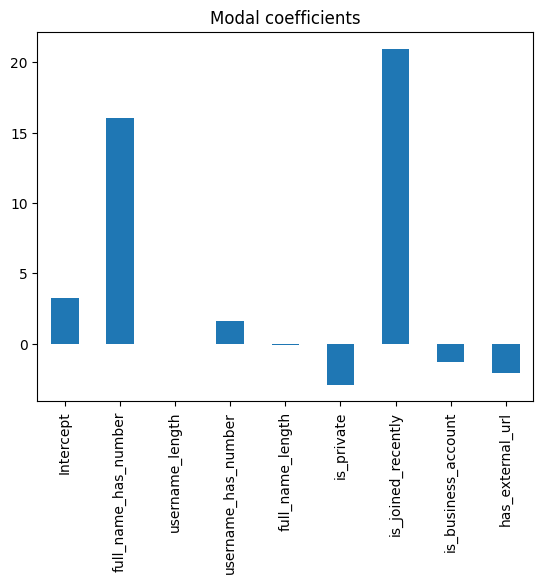

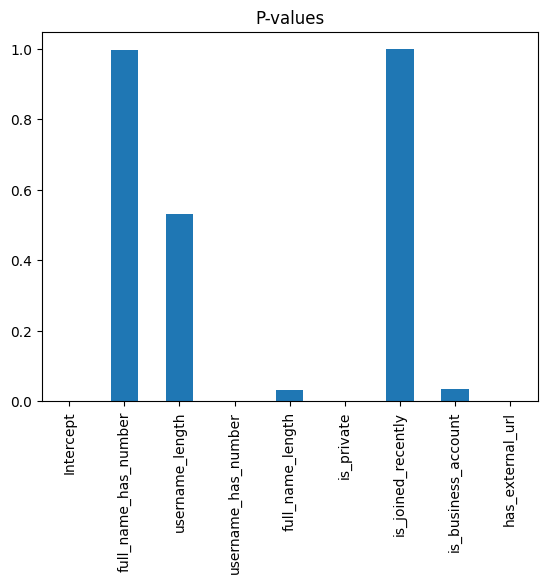

In [ ]:
#make a graph of the coefficients and their p-values

coefficients = model.params
coefficients.plot(kind='bar', title='Modal coefficients')

plt.show()
p_values = model.pvalues
p_values.plot(kind='bar', title='P-values')
plt.show()

## **Conclusão**

Concluindo, neste projeto, nós usamos a regressão logística para prever se uma conta do Instagram é falsa ou não, baseado em algumas variáveis que descrevem o comportamento e as características das contas. Nós usamos a biblioteca dask para ler e manipular os dados, e a biblioteca statsmodels para criar e ajustar o modelo. Nós dividimos os dados em dois conjuntos: treinamento e teste, e usamos o conjunto de treinamento para estimar os coeficientes do modelo. Nós avaliamos a acurácia do modelo usando o conjunto de teste, e obtivemos um valor de 0.91, o que significa que o modelo acertou 91% das previsões. Nós também fizemos dois gráficos para mostrar os coeficientes e os p-valores do modelo, e analisamos quais variáveis eram mais importantes e significativas para o modelo. Nós concluímos que as variáveis que representam intercept e se tem numeros no nome de usuário  eram as mais relevantes e positivas para prever se uma conta é falsa ou não, enquanto as variáveis que representam se a conta é privada, se é de empresa e possui link externo atrelado eram as mais relevantes e negativas para prever se uma conta é falsa ou não. O modelo teve um bom desempenho, mas pode ser melhorado com mais dados e mais variáveis explicativas.